In [1]:
import os
import sys
import pickle
import pathlib

import math
import numpy as np
import pandas as pd
from numpy import asarray
from natsort import natsorted

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import animation
import matplotlib.lines as mlines
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import TwoSlopeNorm

from PIL import Image
import dask.array as da

from IPython.display import display

parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

In [2]:
def ravel_data(channel_patches, max_pixels):
    total_pixels = channel_patches.size

    # flatten image patches for raveling efficiency
    data = channel_patches.reshape(
        -1, np.prod(channel_patches.shape[1:])
    ) 
    if total_pixels > max_pixels:
        num_patches = int(max_pixels / data.shape[1])
        patch_selections = np.random.choice(
            data.shape[0], num_patches, replace=False
        )
        data = data[patch_selections].ravel() 
    else:
        data = data[:].ravel()                      

    return data

In [3]:
def save_figs(dpi=300, format='pdf', out_dir=None, prefix=None, close=True):
    figs = [plt.figure(i) for i in plt.get_fignums()]
    if prefix is not None:
        for f in figs:
            if f._suptitle:
                f.suptitle(f'{prefix} {f._suptitle.get_text()}')
            else:
                f.suptitle(prefix)
    names = [f._suptitle.get_text() if f._suptitle else "" for f in figs]
    out_dir = pathlib.Path(out_dir)
    out_dir.mkdir(exist_ok=True, parents=True)

    for f, n, nm in zip(figs, plt.get_fignums(), names):
        f.savefig(out_dir / f'{n}-{nm}.{format}', dpi=dpi, bbox_inches='tight')
        if close:
            plt.show()
            plt.close(f)

In [4]:
def PlotLatentSpace(main, color_dict, leiden, scatter_point_size, filename, save_dir):

    fig = plt.figure(figsize=(10, 10))
    
    # if VAE clustering
    if leiden:
        num_labels = len(np.unique(main['cluster']))
        num_colors = plt.colormaps['tab20'].N
        palette_multiplier = math.ceil(num_labels / num_colors)
        palette = []
        palette.extend(list(plt.colormaps['tab20'].colors))
        palette = palette * palette_multiplier
        trim = len(palette) - num_labels
        
        if not trim == 0:
            palette = palette[:-trim]

        cluster_color_dict = dict(
            zip(sorted(np.unique(main['cluster'])), palette)
        )
        c = [cluster_color_dict[i] for i in main['cluster']]

        handles = []
        for lbl, color in cluster_color_dict.items():

            handles.append(
                Line2D([0], [0], marker='o', color='w', label=lbl, 
                       markerfacecolor=color, markeredgecolor=None,
                       lw=0.25, markersize=9)
            )

        ax = plt.axes(projection='3d', computed_zorder=False)
        ax.view_init(elev=10, azim=-58)
        ax.scatter(
            main['emb1'], main['emb2'], main['emb3'],
            c=c, ec='k', lw=0.0, s=scatter_point_size
        )

        plt.legend(
            handles=handles, labelspacing=0.15, 
            bbox_to_anchor=(1.1, 1.0)
        )
        
        ax.axis('auto')
        ax.grid(True)
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, f'{filename}.png'), dpi=800)
        plt.show()
        plt.close('all')

        return cluster_color_dict
    
    else:
        c = [color_dict[i] for i in main['Sample']]

        ax = plt.axes(projection='3d', computed_zorder=False)
        ax.view_init(elev=10, azim=-58)
        ax.scatter(
            main['emb1'], main['emb2'], main['emb3'],
            c=c, ec='k', lw=0.0, s=main['size']
        )
        
        handles = []
        for e, i in enumerate(natsorted(main['Sample'].unique())):

            handles.append(
                Line2D([0], [0], marker='o', color='w', label=i,
                       markerfacecolor=color_dict[i], 
                       markeredgecolor=None, lw=0.25, markersize=9)
            )
        handles = [handles[1], handles[2], handles[0]]  # custom order handles
        plt.legend(
            handles=handles, labelspacing=0.15, 
            bbox_to_anchor=(1.16, 1.0)
        )

        ax.axis('auto')
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, f'{filename}.png'), dpi=800)
        plt.show()
        plt.close('all')

        return

In [5]:
def rotation_movie(clustering, main, color_dict, azim_init, num_frames):
    
    fig = plt.figure(figsize=(14.5, 10))
    ax = plt.axes(projection='3d', computed_zorder=False)

    def init():
        if clustering:
            target_col = 'cluster'
        else:
            target_col = 'Sample'

        ax.scatter(
            main['emb1'], main['emb2'], main['emb3'],
            c=[color_dict[i] for i in main[target_col]], 
            s=150000 / len(main), ec='k',linewidth=0.0
        )
        
        ax.axis('auto')
        ax.grid(True)
        ax.grid(True)
        
        ax.set_xlabel('UMAP1')
        ax.set_ylabel('UMAP2')
        ax.set_zlabel('UMAP3')
        
        # add legend
        if clustering:
            
            legend_elements = []
            for e, i in enumerate(natsorted(main[target_col].unique())):
    
                legend_elements.append(
                    Line2D([0], [0], marker='o',
                           color='none',
                           label=f'VAE9_VIG7 cluster {i}',
                           markerfacecolor=color_dict[i],
                           markeredgecolor='none',
                           lw=0.001, markersize=8)
                )
    
            cluster_lgd = ax.legend(
                handles=legend_elements, loc='upper left', prop={'size': 10}, bbox_to_anchor=[1.1, 0.95]
            )
        
        else:   
            legend_elements = []
            for e, i in enumerate(natsorted(main[target_col].unique())):
        
                legend_elements.append(
                    Line2D([0], [0], marker='o',
                           color='none',
                           label=i,
                           markerfacecolor=color_dict[i],
                           markeredgecolor='none',
                           lw=0.001, markersize=8)
                )
        
            cluster_lgd = ax.legend(
                handles=legend_elements, loc='upper left', prop={'size': 10}, bbox_to_anchor=[1.1, 0.95]
            )
        
        plt.tight_layout()
        
        return fig,

    def animate(i, num_frames, azim_init):
        
        i = i * 360/num_frames
        
        if i % 10 == 0:
            print(f'degree = {i}')
        ax.view_init(elev=10.0, azim=(i + azim_init))
        
        return fig,

    anim = animation.FuncAnimation(
        fig, lambda i: animate(i, num_frames, azim_init), init_func=init,
        frames=num_frames, interval=20, blit=True)

    if clustering:
        filename = 'multi-tissue_leiden.mp4'
    else:
        filename = 'multi-tissue_sample.mp4'
    
    anim.save(
        os.path.join(out, filename),
        dpi=200, fps=30, extra_args=['-vcodec', 'libx264'])

In [6]:
# I/O
out = os.path.join(parent_dir, 'output/multi-tissue')
if not os.path.exists(out):
    os.makedirs(out)

with open(os.path.join(
    parent_dir, 
    'input/VAE9_VIG7_multi-tissue/4_histogram_alignment/limits.pkl'), 'rb') as handle:
    limits = pickle.load(handle)

max_pixels = 2_000_000
X_alignment = np.load(
    os.path.join(parent_dir, 
                 'input/VAE9_VIG7_multi-tissue/6_latent_space_LD412/for_alignment_check/X_transform.npy')
)

X_tricolor = np.load(
    os.path.join(parent_dir, 
                 'input/VAE9_VIG7_multi-tissue/6_latent_space_LD412/for_tricolor/X_transform.npy')
)

labels = pd.Series(
    np.load(os.path.join(parent_dir, 
                         'input/VAE9_VIG7_multi-tissue/6_latent_space_LD412/for_tricolor/labels.npy'))
)

main = pd.read_csv(
    os.path.join(parent_dir, 
                 'input/VAE9_VIG7_multi-tissue/6_latent_space_LD412/main.csv')
)

samples = ['CRC097', 'C9', 'CRC102']

markers = {
    'anti_CD3': 0, 'anti_CD45RO': 1, 'Keratin_570': 2, 'aSMA_660': 3, 
    'CD4_488': 4, 'CD45_PE': 5, 'PD1_647': 6, 'CD20_488': 7, 'CD68_555': 8, 
    'CD8a_660': 9, 'CD163_488': 10, 'FOXP3_570': 11, 'PDL1_647': 12, 
    'Ecad_488': 13, 'Vimentin_555': 14, 'CDX2_647': 15, 'LaminABC_488': 16,
    'Desmin_555': 17, 'CD31_647': 18, 'PCNA_488': 19, 'CollagenIV_647': 20
}

antibody_abbrs = {
    'anti_CD3': 'CD3', 'anti_CD45RO': 'CD45RO', 'Keratin_570': 'Keratin', 
    'aSMA_660': 'aSMA', 'CD4_488': 'CD4', 'CD45_PE': 'CD45', 'PD1_647': 'PD1', 
    'CD20_488': 'CD20', 'CD68_555': 'CD68', 'CD8a_660': 'CD8a', 
    'CD163_488': 'CD163', 'FOXP3_570': 'FOXP3', 'PDL1_647': 'PDL1', 
    'Ecad_488': 'ECAD', 'Vimentin_555': 'Vimentin', 'CDX2_647': 'CDX2', 
    'LaminABC_488': 'LaminABC', 'Desmin_555': 'Desmin', 'CD31_647': 'CD31', 
    'PCNA_488': 'PCNA', 'CollagenIV_647': 'CollagenIV'
}

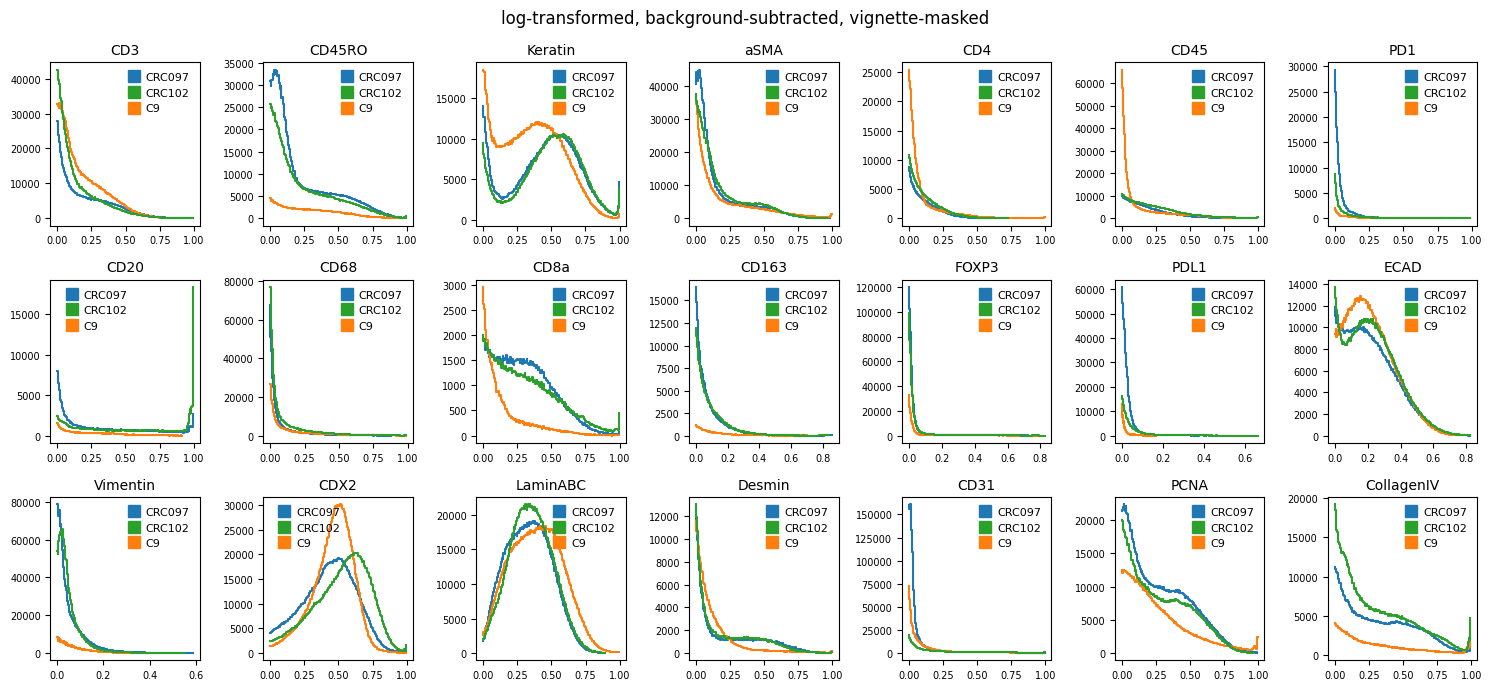

In [7]:
# vizualize histogram alignment

fig, axs = plt.subplots(
    3, np.ceil(len(markers.keys()) / 3).astype('int'),
    figsize=(15, 7)
)
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
for (marker, ch), ax in zip(markers.items(), axs.ravel()):
    handles = []
    if marker in markers.keys():
        for sample, color in zip(samples, colors):
            idx = labels.index[labels == sample]
            channel_patches = X_alignment[idx, :, :, ch]
            raveled_data = ravel_data(
                channel_patches=channel_patches,
                max_pixels=max_pixels
            )
            raveled_data = raveled_data[raveled_data > 0]
            bins = np.linspace(
                *np.percentile(
                    raveled_data, [0.01, 99.99]), 200
            )
            counts, bin_edges = np.histogram(
                raveled_data, bins=bins
            )
            ax.step(
                bin_edges[:-1], counts, where='mid', 
                label=sample.split('-')[-1]
            )
            handle = mlines.Line2D(
                [], [], color=color, marker='s', markersize=8, 
                linestyle='None', label=sample.split('-')[-1]
            )
            handles.append(handle)
            fig.suptitle('log-transformed, background-subtracted, vignette-masked', fontsize=12)
            ax.set_title(antibody_abbrs[marker], fontsize=10)
            ax.tick_params(axis='both', which='major', labelsize=7)
        handles = [handles[0], handles[2], handles[1]] # custom order handles
        ax.legend(fontsize=8)
        ax.legend(
            handles=handles,
            fontsize=8,
            markerscale=1,
            loc='best',
            frameon=False,
            handletextpad=0.1
        )
fig.tight_layout()
save_figs(format='pdf', out_dir=out)

Dropping VAE clusters 29, 31, and 32, as these represent artifacts
Max per-sample percentage for VAE cluster 29 is 0.295
Max per-sample percentage for VAE cluster 31 is 0.054
Max per-sample percentage for VAE cluster 32 is 0.001


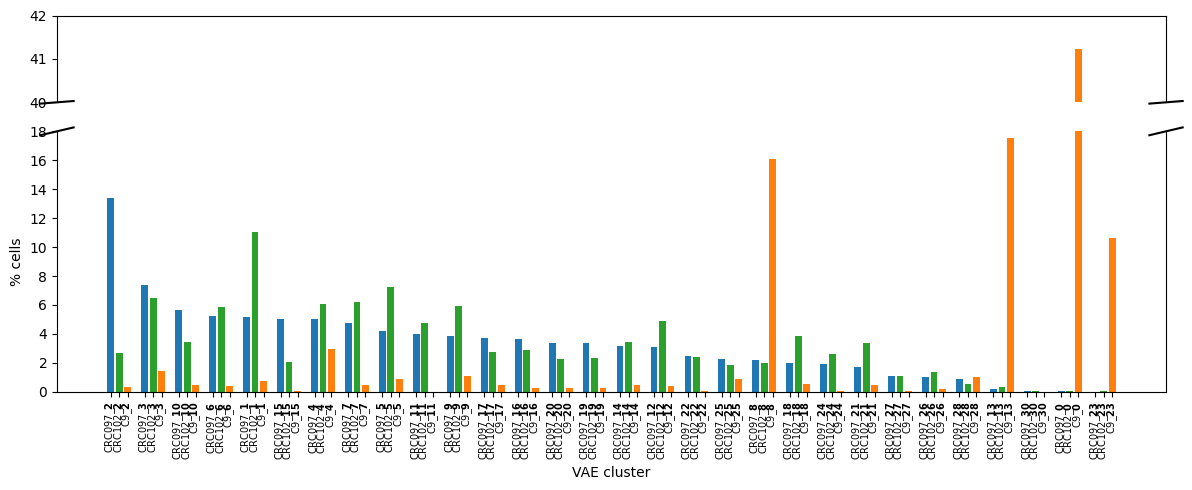

Max per-sample percentage for VAE cluster 30 is 0.078

Percentage for VAE cluster 8 in sample CRC097 2.216
Percentage for VAE cluster 8 in sample CRC102 1.982
Percentage for VAE cluster 8 in sample C9 16.06


In [8]:
# plot barcharts of cluster frequency

# first sort the data

# get cluster counts per sample
main['call'] = main['Sample'] + '_' + main['cluster'].astype(str) 
series = main.groupby('call').size()

# isolate raw sample counts
crc097 = series[series.index.str.contains('CRC097')]
crc102 = series[series.index.str.contains('CRC102')]
c9 = series[series.index.str.contains('C9')]

# calculate the set of VAE cluster labels present in each sample
crc097_set = set([i.split('_')[1] for i in crc097.index])
crc102_set = set([i.split('_')[1] for i in crc102.index])
c9_set = set([i.split('_')[1] for i in c9.index])
crc097_set.difference(crc102_set)
crc097_set.difference(c9_set)

# pad CRC102 and C9 with cluster label 32, which is only present in CRC097
new_row = pd.Series([0.0001], index=['CRC102_32'])
crc102 = pd.concat([crc102, new_row])
new_row = pd.Series([0.0001], index=['C9_32'])
c9 = pd.concat([c9, new_row])

# compute the percentage of clustering cells comprising each sample 
crc097 = (crc097/crc097.sum()) * 100
crc102 = (crc102/crc102.sum()) * 100
c9 = (c9/c9.sum()) * 100

# sort CRC097 cluster in descending order according to size 
crc097.sort_values(ascending=False, inplace=True)
crc097_cluster_order = [int(i.split('_')[1]) for i in crc097.index]

# create a dataframe for CRC097 data
crc097_df = pd.DataFrame({
    'cluster': crc097.index.str.split('_').str[1].astype(int),
    'sample': crc097.index.str.split('_').str[0]
})

crc097_df['call'] = crc097.index
crc097_df['percent'] = crc097.values
crc097_df['percent_crc097'] = (crc097.values/crc097.values) * 100
crc097_df['percent_crc102'] = (crc097.values/crc102.values) * 100
crc097_df['percent_c9'] = (crc097.values/c9.values) * 100

new_index = [i * 4 for i in range(len(crc097_df))]
crc097_df.index = new_index

# create a dataframe for CRC102 data
crc102_df = pd.DataFrame({
    'cluster': crc102.index.str.split('_').str[1].astype(int),
    'sample': crc102.index.str.split('_').str[0]
})

crc102_df['call'] = crc102.index
crc102_df['percent'] = crc102.values
crc102_df['percent_crc097'] = (crc102.values/crc097.values) * 100
crc102_df['percent_crc102'] = (crc102.values/crc102.values) * 100
crc102_df['percent_c9'] = (crc102.values/c9.values) * 100

# sort CRC102 clusters according to previously sorted CRC097 cluster order
crc102_df['cluster'] = pd.Categorical(crc102_df['cluster'], categories=crc097_cluster_order, ordered=True)
crc102_df = crc102_df.sort_values(by='cluster')

# reindex so that the full concatenated data sorts in the desired order
crc102_df.reset_index(drop=True, inplace=True)
new_index = [1 + i * 4 for i in range(len(crc102_df))]
crc102_df.index = new_index

# create a dataframe for C9 data
c9_df = pd.DataFrame({
    'cluster': c9.index.str.split('_').str[1].astype(int),
    'sample': c9.index.str.split('_').str[0]
})
c9_df['call'] = c9.index
c9_df['percent'] = c9.values
c9_df['percent_crc097'] = (c9.values/crc097.values) * 100
c9_df['percent_crc102'] = (c9.values/crc102.values) * 100
c9_df['percent_c9'] = (c9.values/c9.values) * 100

# sort C9 clusters according to previously sorted CRC097 cluster order 
c9_df['cluster'] = pd.Categorical(c9_df['cluster'], categories=crc097_cluster_order, ordered=True)
c9_df = c9_df.sort_values(by='cluster')

# reindex so that the full concatenated data sorts in the desired fashion
c9_df.reset_index(drop=True, inplace=True)
new_index = [2 + i * 4 for i in range(len(c9_df))]
c9_df.index = new_index

# create a dummy dataframe to create space between groups of clusters in the bar chart below 
pad = c9_df.copy()
pad['call'] = [f"{i.split('_')[1]}_pad" for i in pad['call']]
pad['sample'] = 'pad'
pad['percent'] = np.inf
pad['percent_crc097'] = (crc097.values/crc097.values) * 100
new_index = [3 + i * 4 for i in range(len(pad))]
pad.index = new_index

# concatenate sample dataframes together with pad dataframe 
res = pd.concat([crc097_df, crc102_df, c9_df, pad], axis=0)
res.sort_index(inplace=True)

# filter artifactual clusters
print('Dropping VAE clusters 29, 31, and 32, as these represent artifacts')
max_percent_29 = res['percent'][(res['cluster'] == 29) & (res['sample'] != 'pad')].max()
max_percent_31 = res['percent'][(res['cluster'] == 31) & (res['sample'] != 'pad')].max()
max_percent_32 = res['percent'][(res['cluster'] == 32) & (res['sample'] != 'pad')].max()
print(f'Max per-sample percentage for VAE cluster 29 is {round(max_percent_29, 3)}')
print(f'Max per-sample percentage for VAE cluster 31 is {round(max_percent_31, 3)}')
print(f'Max per-sample percentage for VAE cluster 32 is {round(max_percent_32, 3)}')

res = res[~res['cluster'].isin([29, 31, 32])]

# remove consecutive two or more consecutive infs
res = res[~((res['percent'] == np.inf) & (res['percent'].shift() == np.inf))].reset_index(drop=True)

# color bars by sample
colormap = {'CRC097': 'tab:blue', 'CRC102': 'tab:green', 'C9': 'tab:orange', 'pad': 'tab:gray'}
colors = res['sample'].map(colormap)

# plot
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [1, 3]}, figsize=(12, 5))
fig.subplots_adjust(hspace=0.05)  # reduce space between axes
# fig.suptitle(f'VAE cluster frequency showing data for clusters >{filter}% of total cells per sample')

# plot on the top axis (zoomed in on smaller range)
ax1.bar(x=res['call'], height=res['percent'], color=colors)
ax1.yaxis.set_major_locator(MaxNLocator(integer=True))  # ensure integer ticks on y-axis
ax1.set_ylim(40, 42)  # limit the y-axis range for larger values
ax1.spines['bottom'].set_visible(False)  # hide the bottom spine
ax1.tick_params(axis='x', which='both', bottom=False, top=False)

# plot on the bottom axis (zoomed in on smaller values)
ax2.bar(x=res['call'], height=res['percent'], color=colors)
ax2.yaxis.set_major_locator(MaxNLocator(integer=True))  # ensure integer ticks on y-axis
ax2.set_ylim(0, 18)  # limit the y-axis range for smaller values
ax2.spines['top'].set_visible(False)  # hide the top spine

# add diagonal lines to indicate the split in the axes
d = 0.015  # Line size
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d, +d), (-d, +d), **kwargs)  # top-left diagonal
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # adjust for bottom axis
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

ax2.set_xlabel('VAE cluster')
plt.ylabel('% cells')

formatted_labels = [
    rf"{label.split('_')[0]}_$\bf{{{label.split('_')[1]}}}$" for label in res['call'] if not 'pad' in label
]

ax2.set_xticks([i for i in res['call'] if 'pad' not in i])
ax2.set_xticklabels(formatted_labels, rotation=90, fontsize=7)

plt.tight_layout()
fig.savefig(os.path.join(out, 'cluster_freq.pdf'))
plt.show()
plt.close('all')

# max percent Vm30 across samples
max_percent_30 = res['percent'][(res['cluster'] == 30) & (res['sample'] != 'pad')].max()
print(f'Max per-sample percentage for VAE cluster 30 is {round(max_percent_30, 3)}')

# percent Vm8 in each sample
percent_CRC097 = res['percent'][res['call'] == 'CRC097_8'].values[0]
percent_CRC102 = res['percent'][res['call'] == 'CRC102_8'].values[0]
percent_C9 = res['percent'][res['call'] == 'C9_8'].values[0]
print()
print(f'Percentage for VAE cluster 8 in sample CRC097 {round(percent_CRC097, 3)}')
print(f'Percentage for VAE cluster 8 in sample CRC102 {round(percent_CRC102, 3)}')
print(f'Percentage for VAE cluster 8 in sample C9 {round(percent_C9, 3)}')

In [9]:
# report stats
c9_cluster_sum = res[res['call'].isin(['C9_0', 'C9_8', 'C9_13', 'C9_23'])].sum()['percent']
print(f'C9_0, C9_8, C9_13, and C9_23 account for {round(c9_cluster_sum, 1)}% of cells in C9')

crc097_2 = res['percent'][res['call'].isin(['CRC097_2'])].values[0]
crc102_2 = res['percent'][res['call'].isin(['CRC102_2'])].values[0]
print(f'CRC097 has {round(crc097_2/crc102_2, 1)}% more cluster 2 cells than CRC102')

crc102_1 = res['percent'][res['call'].isin(['CRC102_1'])].values[0]
crc097_1 = res['percent'][res['call'].isin(['CRC097_1'])].values[0]
print(f'CRC102 has {round(crc102_1/crc097_1, 1)}% more cluster 1 cells than CRC097')
print()

C9_0, C9_8, C9_13, and C9_23 account for 85.5% of cells in C9
CRC097 has 4.9% more cluster 2 cells than CRC102
CRC102 has 2.1% more cluster 1 cells than CRC097



In [10]:
# compute channel z-scores clustermap input

# compute median values of per patch, per channel pixel intensity medians
X_alignment = da.from_array(X_alignment)
medians_alignment = da.mean(X_alignment, axis=(1, 2)).compute()
clustermap_medians = pd.DataFrame(columns=[i for i in markers.keys()], data=medians_alignment)

# reverse sample and cluster order in call for plotting
clustermap_medians['cluster'] = main['call']

# remove sample-specific clusters with low-confidence protein signatures by removing those <0.1% of their respective tissue 
percent_filter = 0.1
clusters_to_drop = res['call'][(res['percent'] <= percent_filter)]

clustermap_input = clustermap_medians.groupby('cluster').median()
clustermap_input = clustermap_input[~clustermap_input.index.isin(clusters_to_drop)]

# compute per channel z-scores across clusters
clustermap_input = (
    (clustermap_input-clustermap_input.mean())/clustermap_input.std()
)
clustermap_input.fillna(0, inplace=True)

# filter clustermap_input according to clusters shown in frequency bar chart above 
clustermap_input = clustermap_input[clustermap_input.index.isin(res['call'])]

# flip order of sample/cluster names in index for plotting heatmap 
clustermap_input.index = [i.split('_')[1] + '_' + i.split('_')[0] for i in clustermap_input.index]

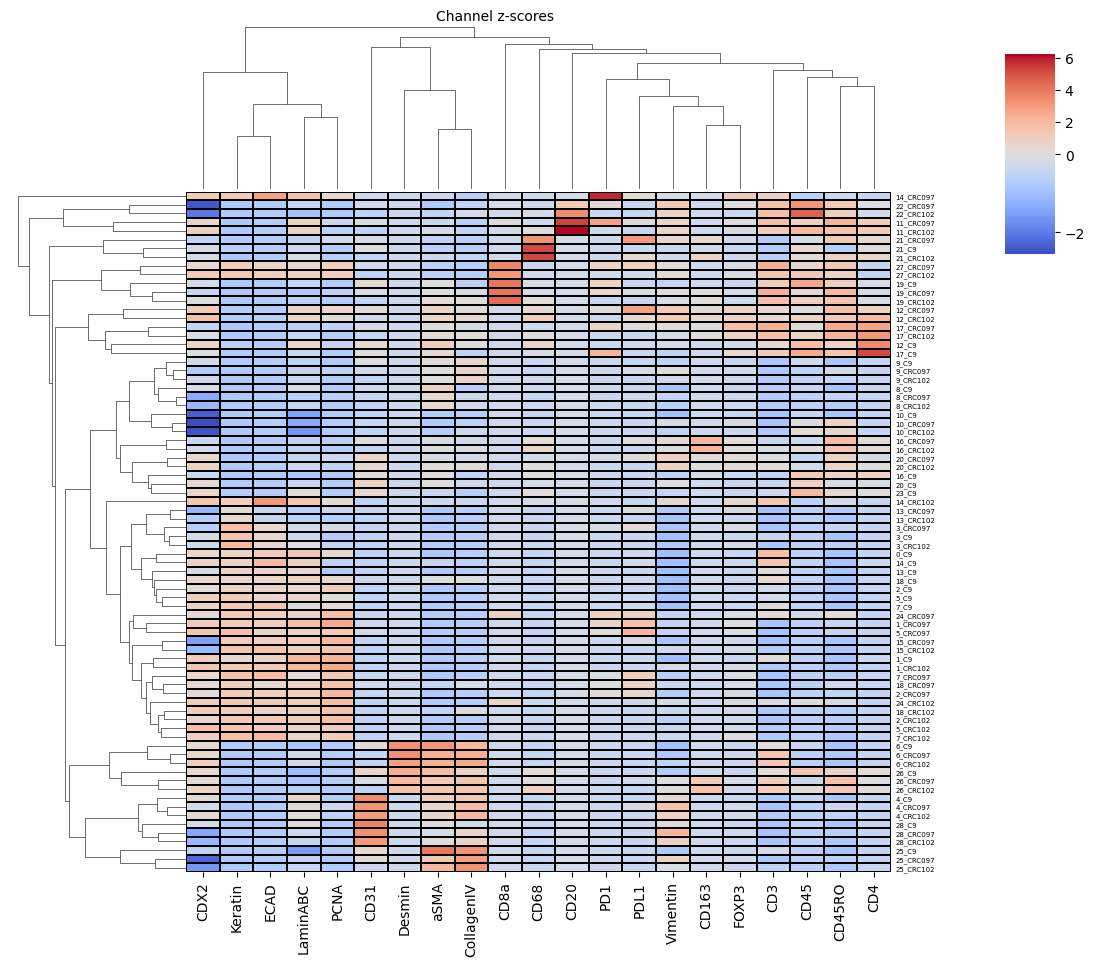

In [11]:
# plot CRC097/CRC102/C9 clustermap

# zero-center colorbar
norm = TwoSlopeNorm(
    vcenter=0, vmin=clustermap_input.min().min(), 
    vmax=clustermap_input.max().max()
)

g = sns.clustermap(
        clustermap_input, cmap='coolwarm', standard_scale=None, 
        yticklabels=1, xticklabels=1, linewidths=0.1, linecolor='k', 
        cbar=True, norm=norm 
)
g.ax_heatmap.set_xticklabels(
    [antibody_abbrs[i.get_text()] for i 
     in g.ax_heatmap.get_xticklabels()], rotation=90
)
g.ax_heatmap.set_yticklabels(
    [i.get_text() for i in g.ax_heatmap.get_yticklabels()], 
    rotation=0, fontsize=5
)
g.ax_cbar.set_position([1.01, 0.75, 0.05, 0.2])
g.fig.suptitle('Channel z-scores', y=0.995, fontsize=10)
g.ax_heatmap.yaxis.set_tick_params(length=0.05, width=0.01)
plt.savefig(
    os.path.join(out, 'channel_z-scores_CRC097_102_C9.pdf'), 
    bbox_inches='tight'
)
plt.show()

In [12]:
# compute dendrogram statistics

def trace_singletons(harch_idx, Z, n):
    """
    Trace the contents of a hierarchical cluster back to the singleton observations.
    Args:
        harch_idx: index of the hierarchical cluster to trace.
        Z: linkage matrix.
        n: number of original observations.
    Returns:
        set of singleton indices contained in the hierarchical cluster.
    """
    if harch_idx < n:
        # this is a singleton index
        return {harch_idx}
    else:
        # this is a hierarchical index; trace its two branches
        row = Z[harch_idx - n]
        left = trace_singletons(int(row[0]), Z, n)
        right = trace_singletons(int(row[1]), Z, n)
        return left.union(right)


n = len(clustermap_input)
Z = g.dendrogram_row.linkage

# trace two cluster merges back to singletons
two_cluster_merges = Z[Z[:, 3] == 2]
cluster_pairs = []
for e in range(len(two_cluster_merges)):
    row = two_cluster_merges[e]
    branch1_singletons = trace_singletons(int(row[0]), Z, n)
    branch2_singletons = trace_singletons(int(row[1]), Z, n)
    total_singletons = branch1_singletons | branch2_singletons
    cluster_labels = [clustermap_input.index[i] for i in total_singletons]
    cluster_pairs.append(cluster_labels)
df_pairs = pd.DataFrame(cluster_pairs, columns=['cluster1', 'cluster2'])
print()
print('2-element hierarchical merges involving matched VAE cluster labels between CRC097 and CRC102')
df_pairs_filt = df_pairs[
    (df_pairs['cluster1'].str.split('_').str[0] == df_pairs['cluster2'].str.split('_').str[0]) &
    (
        (df_pairs['cluster1'].str.split('_').str[1].isin(['CRC097', 'CRC102'])) &
        (df_pairs['cluster2'].str.split('_').str[1].isin(['CRC097', 'CRC102']))
    )
].reset_index(drop=True, inplace=False)
display(df_pairs_filt)
print()

# trace three cluster merges back to singletons
three_cluster_merges = Z[Z[:, 3] == 3]
cluster_triples = []
for e in range(len(three_cluster_merges)):
    row = three_cluster_merges[e]
    branch1_singletons = trace_singletons(int(row[0]), Z, n)
    branch2_singletons = trace_singletons(int(row[1]), Z, n)
    total_singletons = branch1_singletons | branch2_singletons
    cluster_labels = [clustermap_input.index[i] for i in total_singletons]
    cluster_triples.append(cluster_labels)
df_triples = pd.DataFrame(cluster_triples, columns=['cluster1', 'cluster2', 'cluster3'])
print('3-element hierarchical merges involving matched VAE cluster labels between CRC097, CRC102, and C9')
df_triples_filt = df_triples[
    (df_triples['cluster1'].str.split('_').str[0] == df_triples['cluster2'].str.split('_').str[0]) &
    (df_triples['cluster1'].str.split('_').str[0] == df_triples['cluster3'].str.split('_').str[0])
].reset_index(drop=True, inplace=False)
display(df_triples_filt)
print()


2-element hierarchical merges involving matched VAE cluster labels between CRC097 and CRC102


cluster1   cluster2
0    8_CRC097   8_CRC102
1    9_CRC097   9_CRC102
2   10_CRC097  10_CRC102
3   13_CRC097  13_CRC102
4    6_CRC102   6_CRC097
5   20_CRC097  20_CRC102
6    4_CRC102   4_CRC097
7   16_CRC102  16_CRC097
8   15_CRC102  15_CRC097
9   26_CRC097  26_CRC102
10  28_CRC097  28_CRC102
11  25_CRC097  25_CRC102
12  19_CRC097  19_CRC102
13  17_CRC097  17_CRC102
14  27_CRC097  27_CRC102
15  22_CRC102  22_CRC097
16  12_CRC097  12_CRC102
17  11_CRC097  11_CRC102


3-element hierarchical merges involving matched VAE cluster labels between CRC097, CRC102, and C9


cluster1   cluster2   cluster3
0    9_CRC097   9_CRC102       9_C9
1        3_C9   3_CRC097   3_CRC102
2    8_CRC097   8_CRC102       8_C9
3    4_CRC102       4_C9   4_CRC097
4   10_CRC097      10_C9  10_CRC102
5    6_CRC102       6_C9   6_CRC097
6       28_C9  28_CRC097  28_CRC102
7       19_C9  19_CRC097  19_CRC102
8   26_CRC097  26_CRC102      26_C9
9   25_CRC097  25_CRC102      25_C9
10  21_CRC102      21_C9  21_CRC097

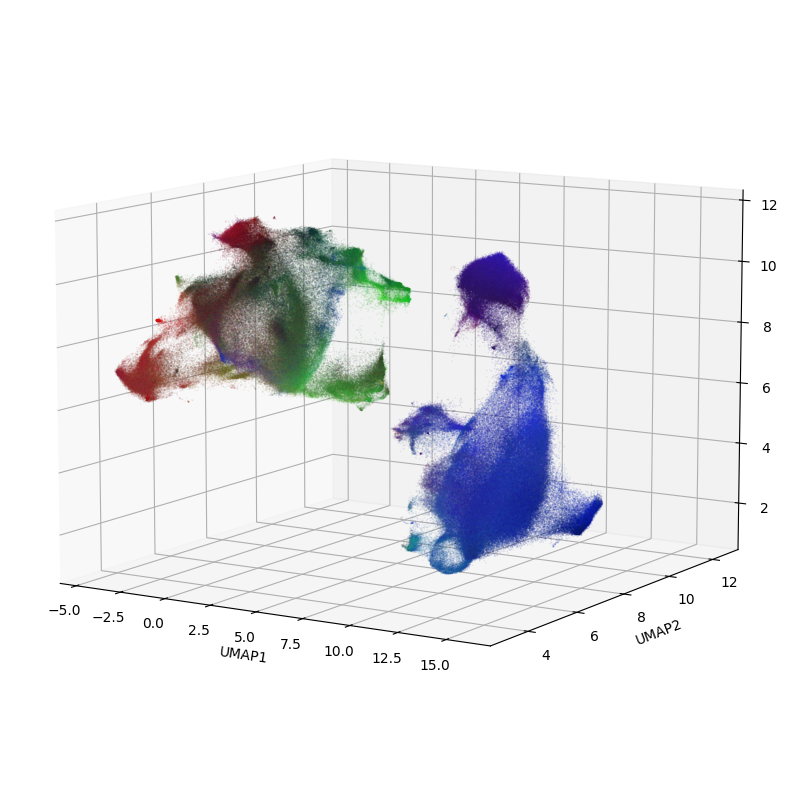

In [13]:
# generate tricolor scatter plot

# compute median values of per patch, per channel pixel intensity medians
X_tricolor = da.from_array(X_tricolor)
medians_tricolor = da.median(X_tricolor, axis=(1, 2)).compute()
scatterplot_medians = pd.DataFrame(columns=[i for i in markers.keys()], data=medians_tricolor)
scatterplot_medians['emb1'] = main['emb1']
scatterplot_medians['emb2'] = main['emb2']
scatterplot_medians['emb3'] = main['emb3']

for c, ch in zip(['blue', 'red', 'green'], ['Keratin_570', 'aSMA_660', 'CD45_PE']):
    scatterplot_medians[f'{c}_norm'] = (
        (scatterplot_medians[ch] - scatterplot_medians[ch].min()) / 
        (scatterplot_medians[ch].max() - scatterplot_medians[ch].min())
    )

# combine normalized RGB values into a single column representing colors
scatterplot_medians['color'] = scatterplot_medians.apply(
    lambda row: (row['red_norm'], row['green_norm'], row['blue_norm']), axis=1
)

fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d', computed_zorder=False)
ax.view_init(elev=10, azim=-58)

ax.scatter(
    scatterplot_medians['emb1'], scatterplot_medians['emb2'], scatterplot_medians['emb3'],
    c=scatterplot_medians['color'], linewidth=0.1, s=500000 / len(scatterplot_medians), alpha=0.1
)

ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_zlabel('UMAP3')
ax.axis('auto')
ax.tick_params(labelsize=10)
ax.grid(True)

plt.savefig(os.path.join(out, 'tricolor.png'), bbox_inches='tight', dpi=800)
plt.show()
plt.close('all')

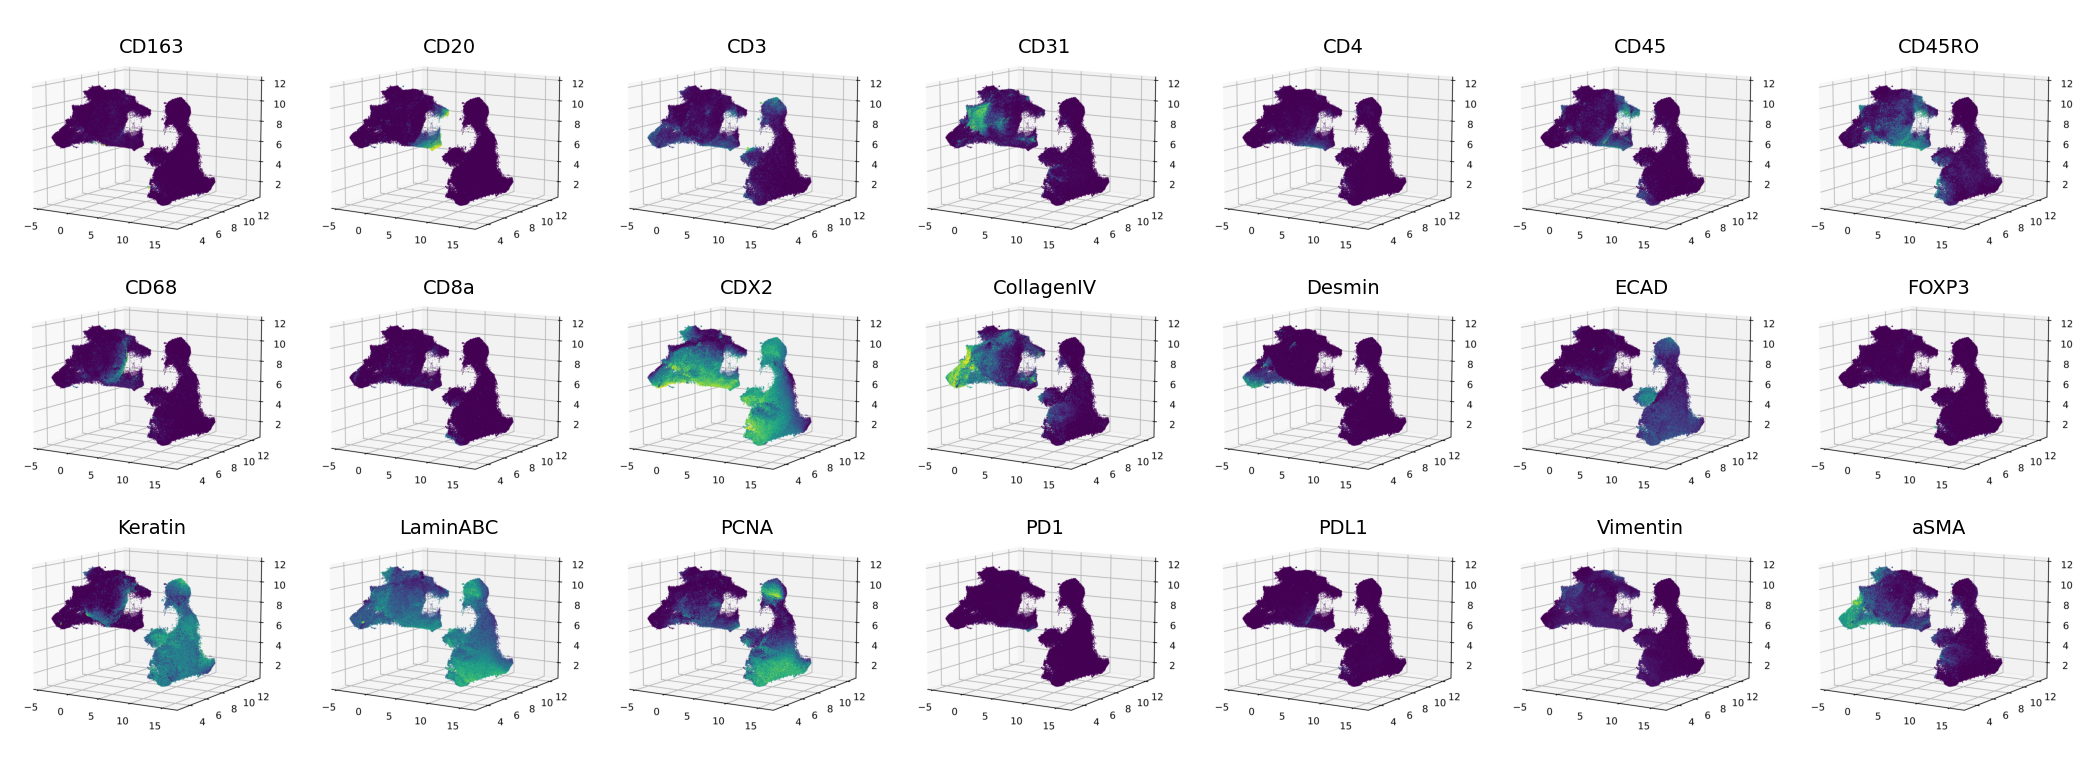

In [14]:
# generate channel intensity plots
channel_out = os.path.join(parent_dir, 'output/multi-tissue/channels')
if not os.path.exists(channel_out):
    os.makedirs(channel_out)

channel_medians = pd.DataFrame(columns=[i for i in markers.keys()], data=medians_alignment)
channel_medians['emb1'] = main['emb1']
channel_medians['emb2'] = main['emb2']
channel_medians['emb3'] = main['emb3']

# generate individual channel PNG image files
for name in markers.keys():
    if not os.path.exists(os.path.join(channel_out, f'{antibody_abbrs[name]}.png')):

        fig = plt.figure()
        ax = plt.axes(projection='3d', computed_zorder=False)
        ax.view_init(elev=10, azim=-58)
        ax.scatter(
            channel_medians['emb1'],
            channel_medians['emb2'],
            channel_medians['emb3'],
            c=channel_medians[name], linewidth=0.1,
            s=500000 / len(channel_medians),
        )

        ax.axis('auto')
        ax.tick_params(labelsize=10)
        ax.grid(True)
        plt.savefig(
            os.path.join(channel_out, f'{antibody_abbrs[name]}.png'), 
            bbox_inches='tight', dpi=800
        )
        plt.close('all')

# generate facetgrid showing all plots together
data_melt = (
    main[list(markers.keys()) + ['emb1', 'emb2']]
    .sample(frac=0.1)
    .reset_index(drop=True)
    .melt(id_vars=['emb1', 'emb2'], var_name='abx')
)

long_table = pd.DataFrame(columns=['channel', 'image'])
for e, file in enumerate(os.listdir(channel_out)):
    if (file.endswith('.png') and not file.endswith('combined.png')):
        channel_name = file.split('.png')[0]
        img = Image.open(os.path.join(channel_out, file))
        arr = asarray(img)
        long_table.loc[e, 'channel'] = channel_name
        long_table.loc[e, 'image'] = arr

long_table.sort_values(by='channel', inplace=True)

g = sns.FacetGrid(
    long_table, col='channel', col_wrap=7, sharex=False, sharey=False,
    height=3.0, aspect=1.0
)
g.fig.subplots_adjust(hspace=-0.55)
g.map(
    lambda image, **kwargs: (plt.imshow(image.values[0]), plt.grid(False)), 
    'image'
)

for ax in g.axes.flatten():
    ax.axis('off')

g.set_titles(col_template="{col_name}", size=14, fontweight='normal', y=0.81)

g.fig.tight_layout()

plt.savefig(
    os.path.join(out, 'combined.png'), bbox_inches='tight', dpi=800
)
plt.show()
plt.close('all')

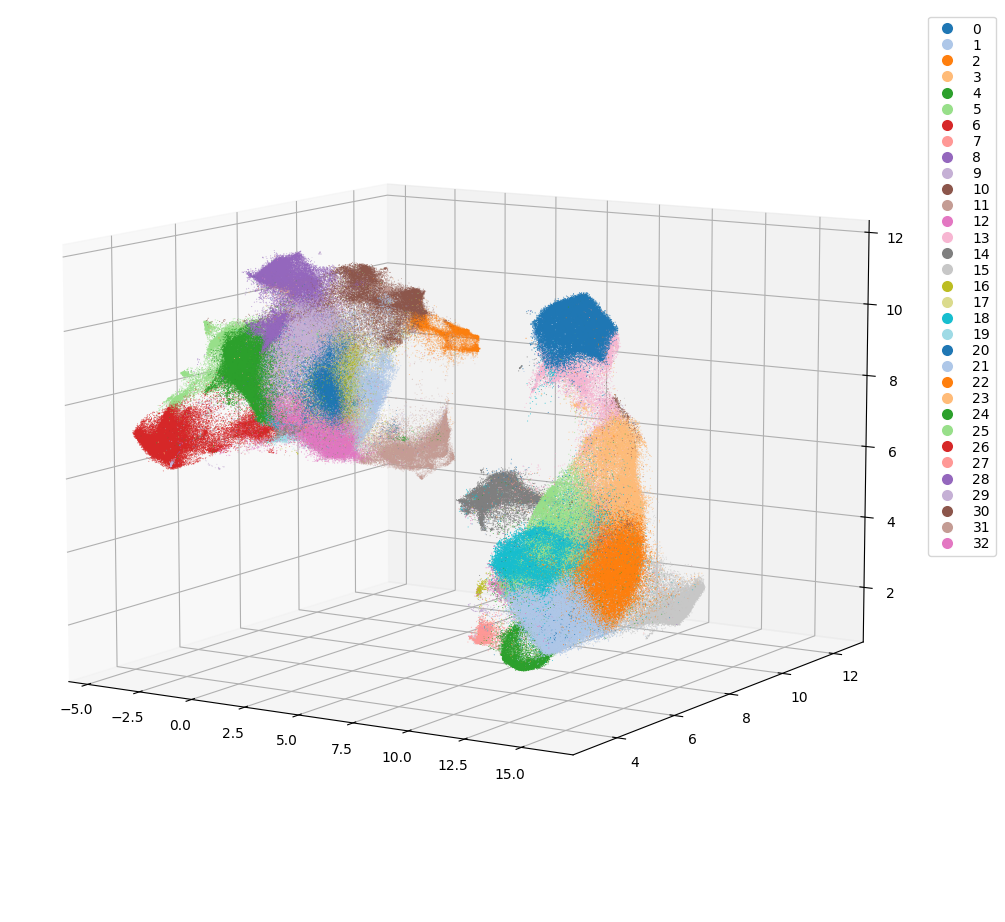

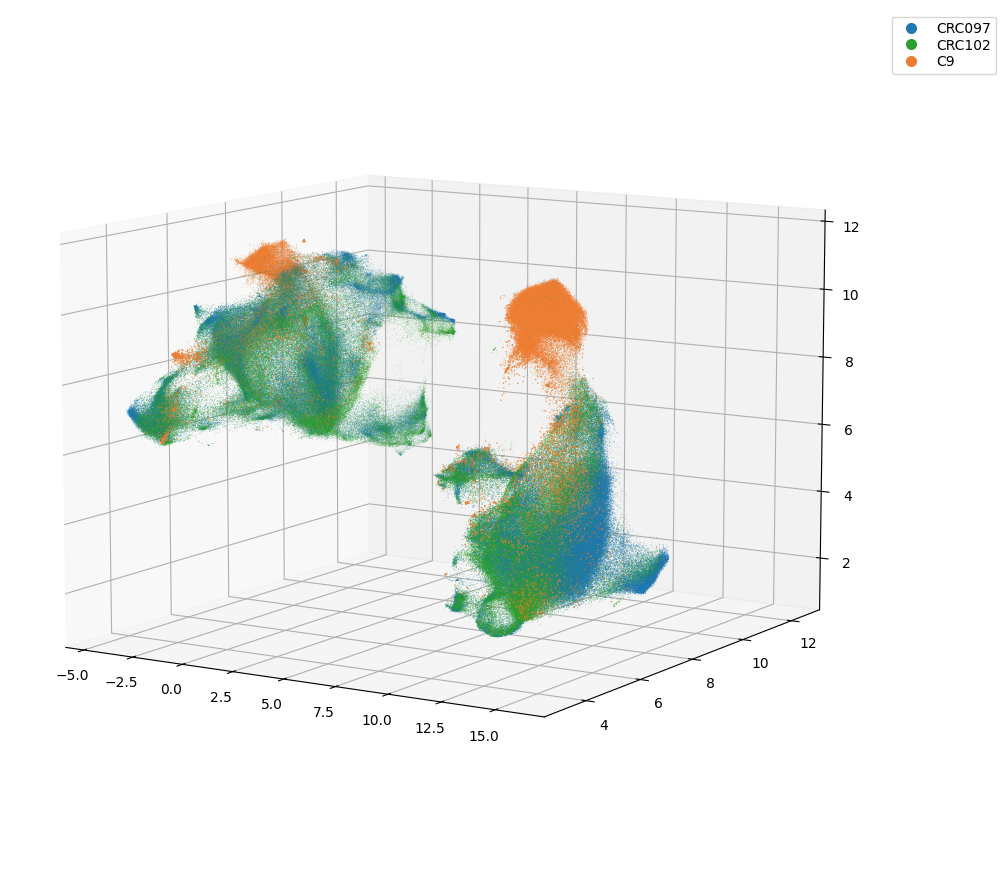

In [15]:
# plot UMAP colored by Leiden clusters 
cluster_color_dict = PlotLatentSpace(
    main=main,
    color_dict=None,
    leiden=True,
    scatter_point_size=350000 / len(main),
    filename='leiden_umap',
    save_dir=out
    )

# plot UMAP colored by sample labels 
sample_color_dict = {
    'C9': np.array([0.92941176, 0.49019608, 0.19215686]),
    'CRC102': np.array([0.17254902, 0.62745098, 0.17254902]),
    'CRC097': np.array([0.12156863, 0.46666667, 0.70588235]),
}

# optimize scatter point sizes for clarity
res1 = main[main['Sample'].isin(['CRC097', 'CRC102'])]
res2 = main[
    (main['Sample'].isin(['C9'])) & 
    (main['cluster'].isin([0, 4, 8, 13, 23, 28]))
]
res3 = pd.concat([res1, res2], axis=0).sample(frac=1.0)
res3['size'] = 1

res4 = main[
    (main['Sample'].isin(['C9'])) & 
    ~(main['cluster'].isin([0, 4, 8, 13, 23, 28]))
].copy()
res4['size'] = 5

main_scramble = pd.concat([res3, res4], axis=0)

# size multiplier
main_scramble['size'] = [
    i * (144000 / len(main_scramble)) for i in main_scramble['size']
]

_ = PlotLatentSpace(
    main=main_scramble,
    color_dict=sample_color_dict,
    leiden=False,
    scatter_point_size=None,
    filename='sample_umap',
    save_dir=out
    )

Multi-tissue cluster 0


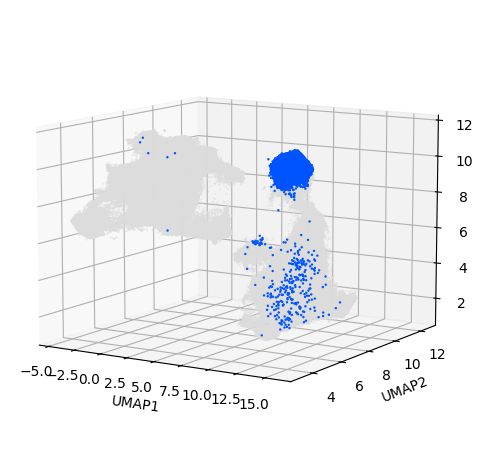

Multi-tissue cluster 1


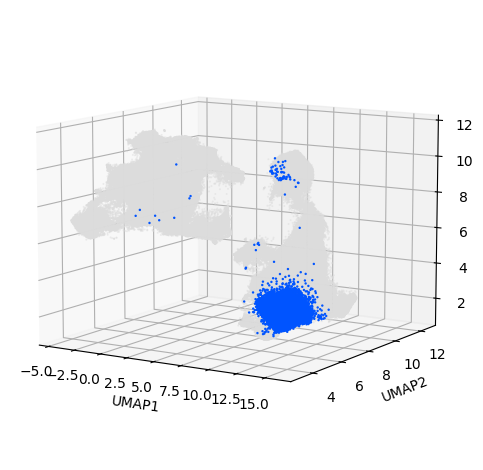

Multi-tissue cluster 2


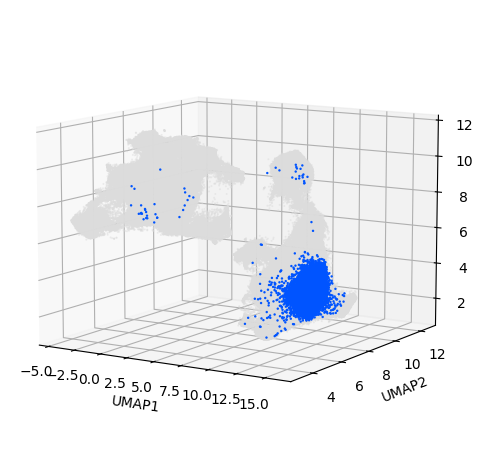

Multi-tissue cluster 3


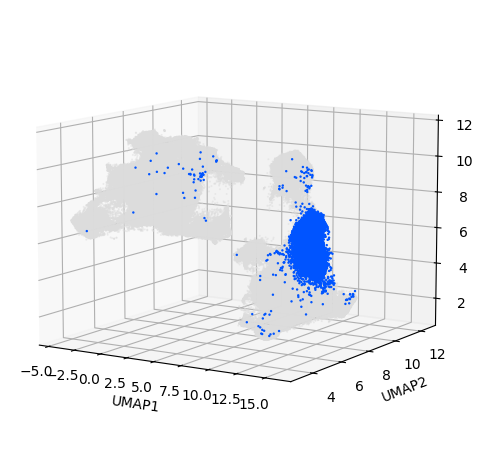

Multi-tissue cluster 4


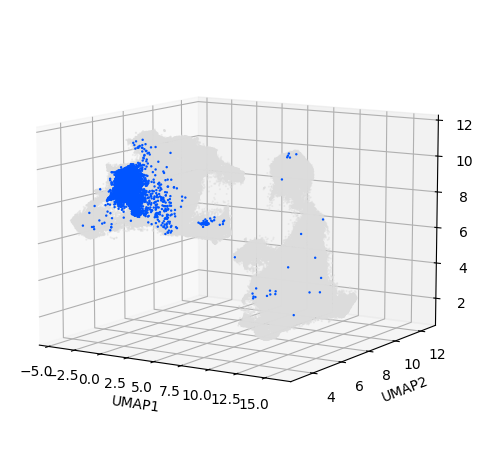

Multi-tissue cluster 5


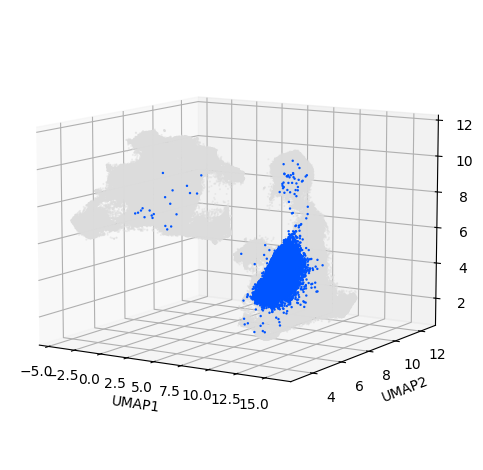

Multi-tissue cluster 6


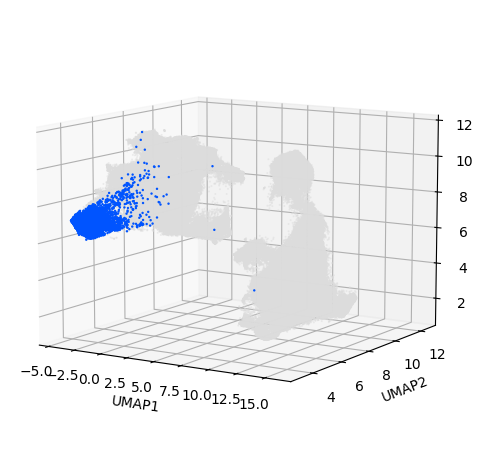

Multi-tissue cluster 7


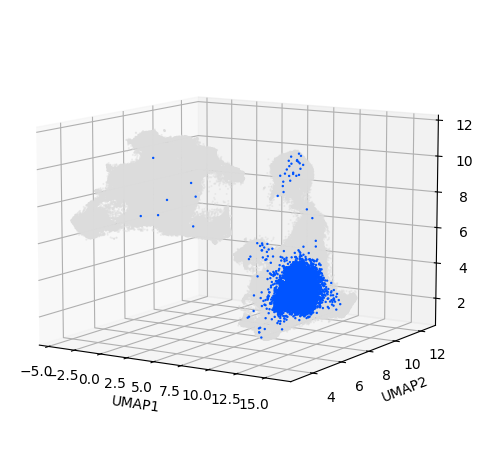

Multi-tissue cluster 8


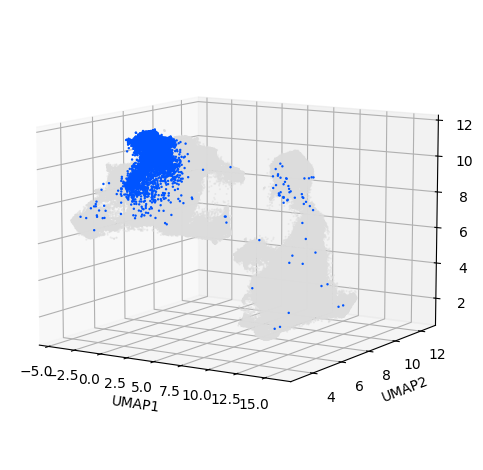

Multi-tissue cluster 9


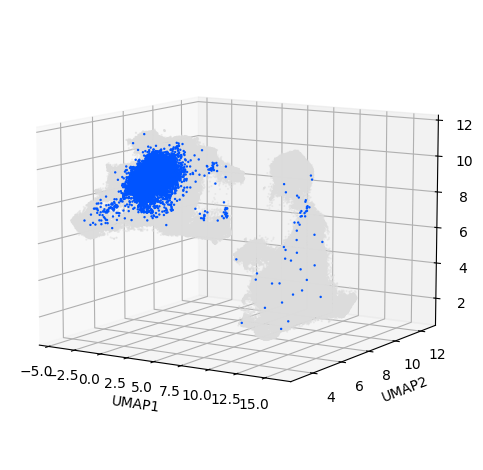

Multi-tissue cluster 10


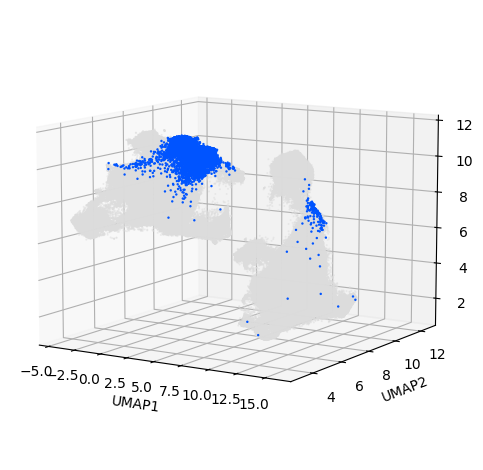

Multi-tissue cluster 11


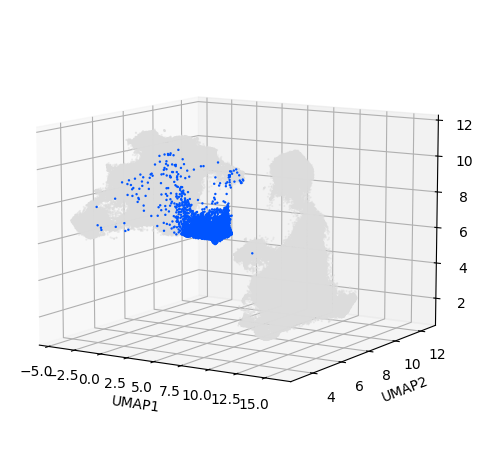

Multi-tissue cluster 12


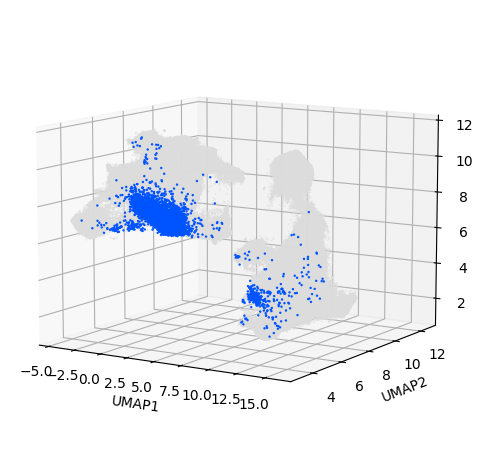

Multi-tissue cluster 13


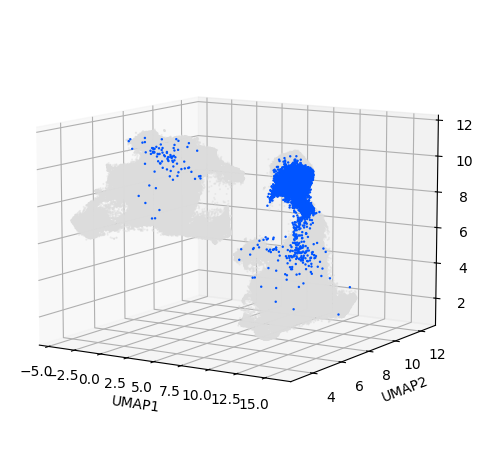

Multi-tissue cluster 14


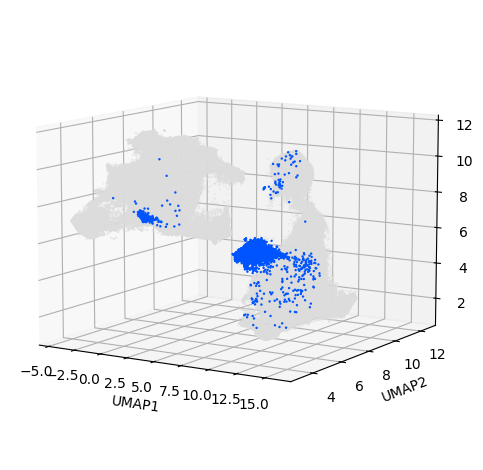

Multi-tissue cluster 15


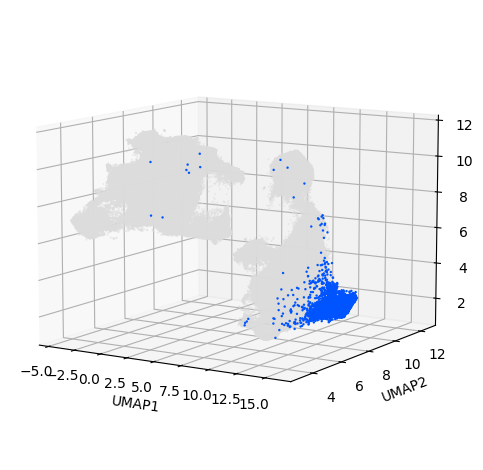

Multi-tissue cluster 16


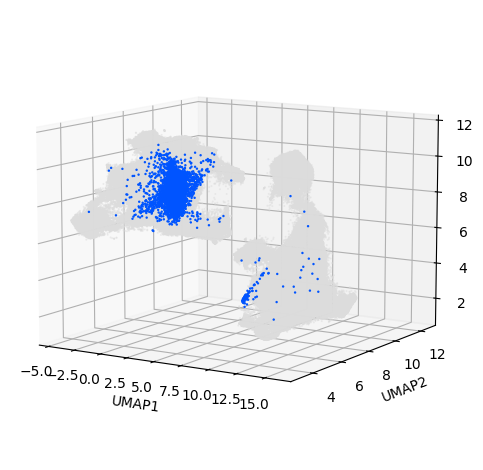

Multi-tissue cluster 17


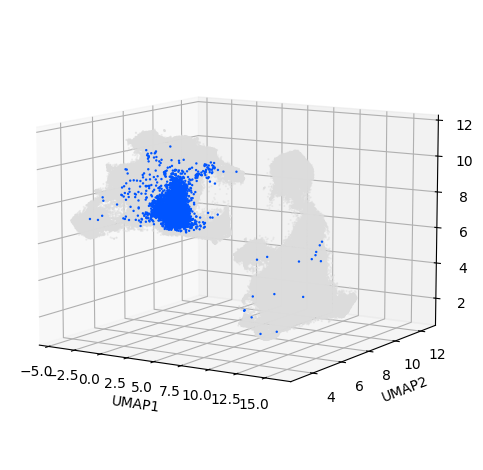

Multi-tissue cluster 18


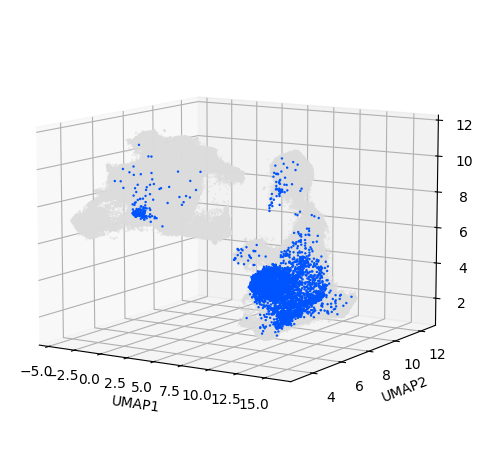

Multi-tissue cluster 19


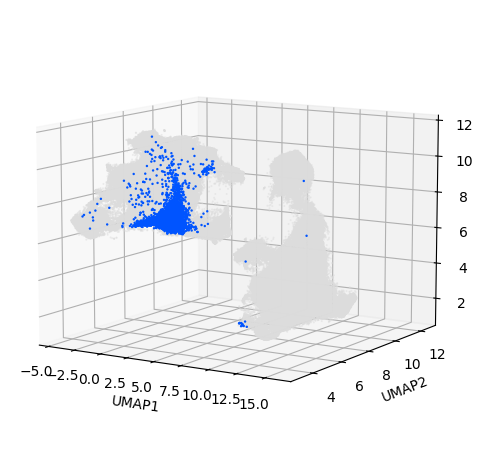

Multi-tissue cluster 20


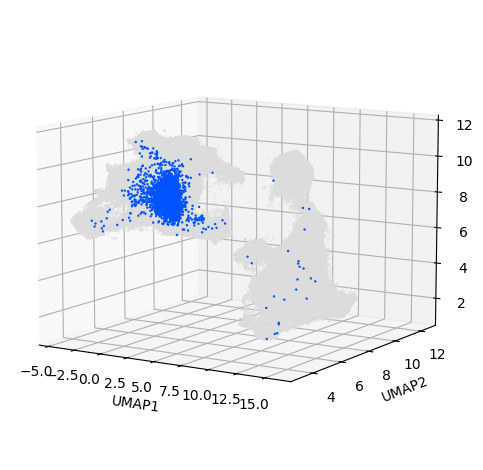

Multi-tissue cluster 21


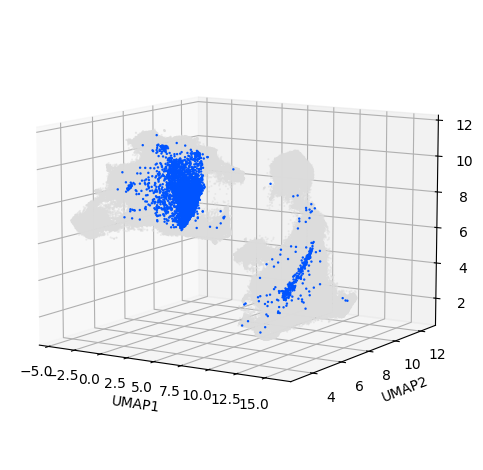

Multi-tissue cluster 22


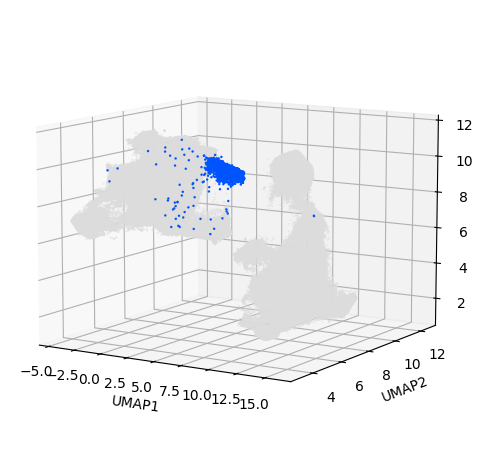

Multi-tissue cluster 23


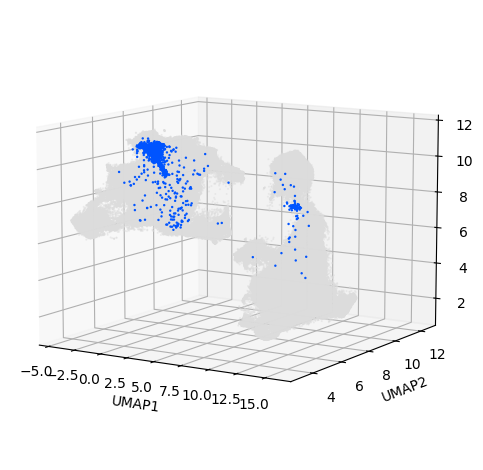

Multi-tissue cluster 24


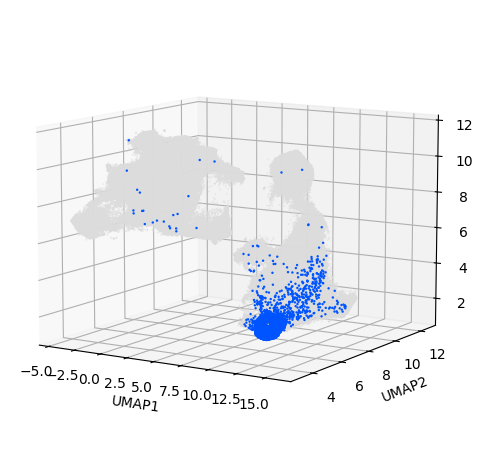

Multi-tissue cluster 25


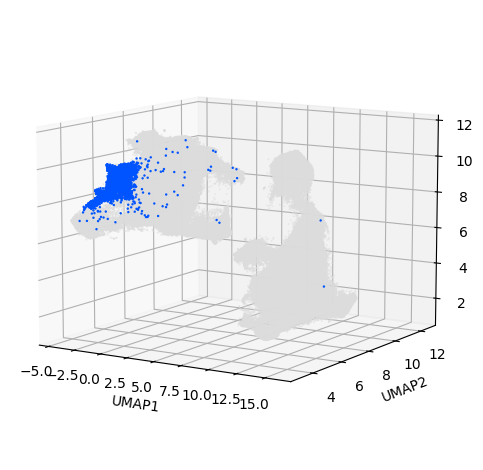

Multi-tissue cluster 26


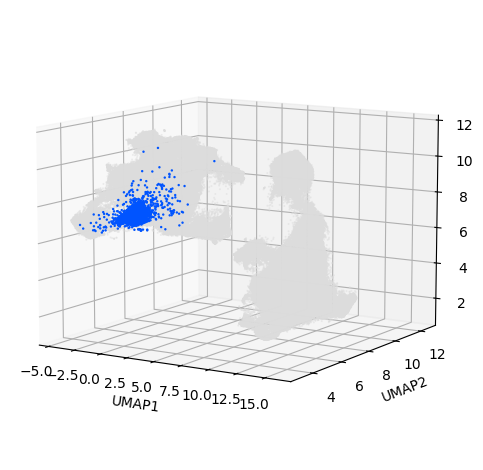

Multi-tissue cluster 27


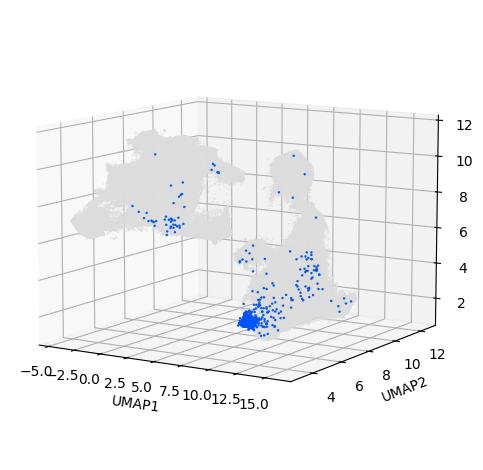

Multi-tissue cluster 28


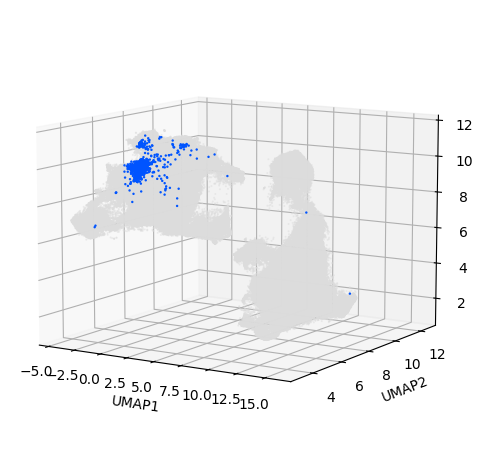

Multi-tissue cluster 29


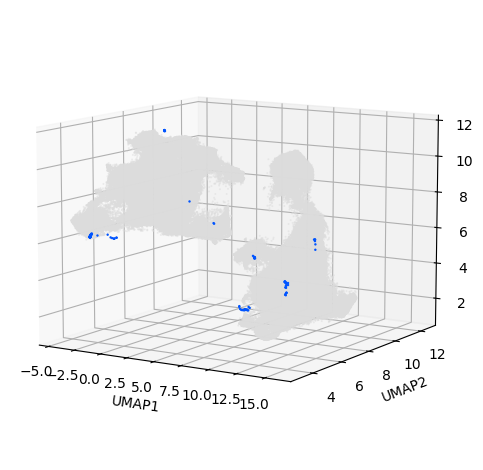

Multi-tissue cluster 30


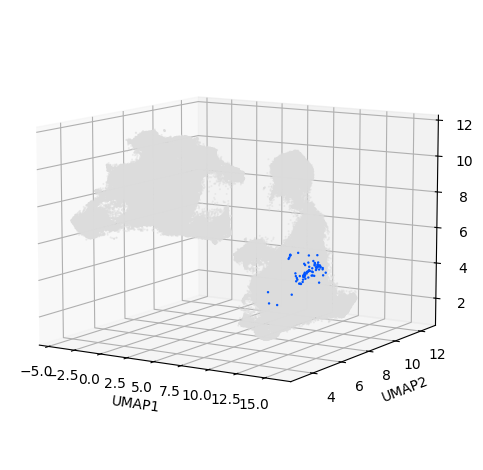

Multi-tissue cluster 31


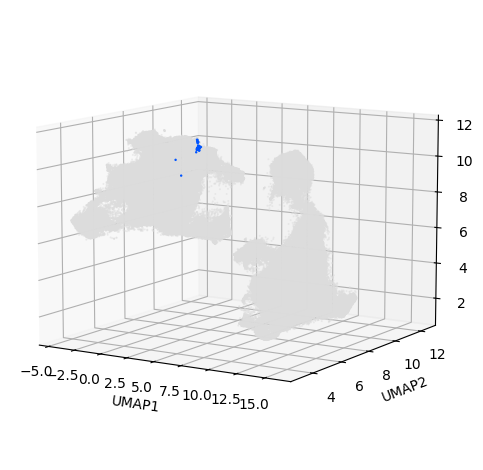

Multi-tissue cluster 32


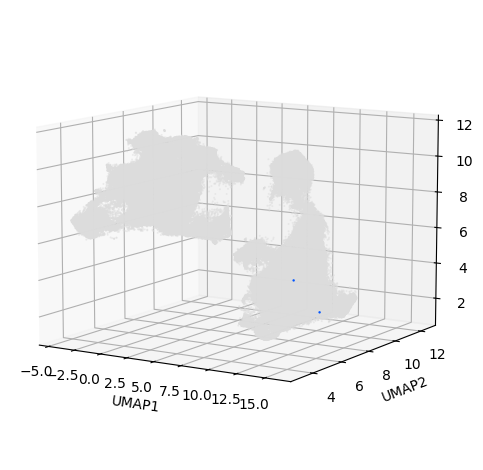

In [16]:
# plot cluster highlights
highlights_out = os.path.join(parent_dir, 'output/multi-tissue/cluster_highlights')
if not os.path.exists(highlights_out):
    os.makedirs(highlights_out)

data = main.sample(frac=0.3)

for i in sorted(data['cluster'].unique()):
   
    print(f'Multi-tissue cluster {i}')
    
    fig = plt.figure()
    ax = plt.axes(projection='3d', computed_zorder=False)
    ax.view_init(elev=10, azim=-58)

    ax.scatter(
        data['emb1'],
        data['emb2'],
        data['emb3'],
        c='gainsboro', linewidth=0.0, s=2, alpha=0.5
    )
    ax.scatter(
        data['emb1'][data['cluster'] == i],
        data['emb2'][data['cluster'] == i],
        data['emb3'][data['cluster'] == i],
        color=(0, 0.33, 1), linewidth=0.0, s=3, alpha=1,
    )
    ax.set_xlabel('UMAP1')
    ax.set_ylabel('UMAP2')
    ax.set_zlabel('UMAP3')

    ax.axis('auto')
    ax.tick_params(labelsize=10)
    ax.grid(True)
    plt.tight_layout()
    
    plt.savefig(os.path.join(highlights_out, f'multi-tissue_cluster_{i}.png'), dpi=800)
    plt.show()

In [17]:
# generate and save animations
# starting azimuth
azim_init = -58

# number of frames to complete 360 degree rotation lower values allow for more rapid computation
num_frames = 360

if not os.path.exists(os.path.join(out, 'multi-tissue_leiden.mp4')):
    print(f'Saving rotating plot for multi-tissue UMAP colored by Leiden cluster...')
    rotation_movie(clustering=True, main=main, color_dict=cluster_color_dict, azim_init, num_frames)
    print()

if not os.path.exists(os.path.join(out, 'multi-tissue_sample.mp4')):
    print(f'Saving rotating plot for multi-tissue UMAP colored by tissue sample...')
    rotation_movie(clustering=False, main=main, color_dict=sample_color_dict, azim_init=azim_init, num_frames=num_frames)
    print()

print('Complete!')

SyntaxError: positional argument follows keyword argument (2430949621.py, line 10)